In [1]:
import numpy as np
#from Tests_ODaDiL_CWRU import test_dadil, test_odadil, test_forgetting_odadil
from Tests_ODaDiL import test_dadil, test_odadil, test_forgetting_odadil
import os
import pickle
import matplotlib.pyplot as plt
import torch

C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())
C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_samples = 1000
batch_size = 200
n_atoms = 8
n_classes = 10
n_iter = 60

# Toy datasets

In [3]:
list_of_datasets = []
for i in range(1, 11):
    dataset = np.load(f'data2/toy_non_linear_100d_dataset_{i}.npy')
    list_of_datasets.append(dataset)

In [ ]:
results, dictionary = test_dadil([list_of_datasets[0]], n_samples, n_classes, n_atoms, batch_size, n_iter)

In [5]:
results

{'lin': {'wda': 0.885,
  'e': 0.5,
  'e_ot': 0.627,
  'r': 0.585,
  'r_ot': 0.5999999999999999},
 'rbf': {'wda': 0.765, 'e': 0.485, 'e_ot': 0.67, 'r': 0.52, 'r_ot': 0.745}}

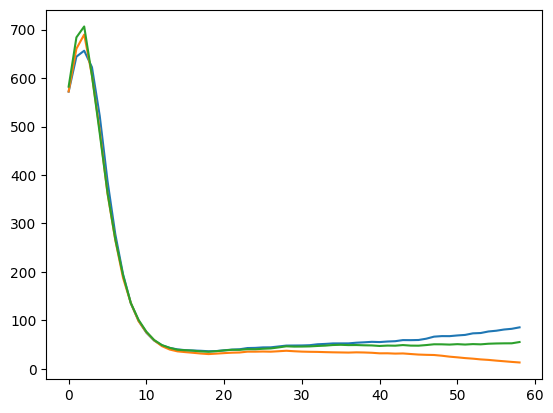

In [12]:
fig, ax = plt.subplots()

for elt in dictionary.history['atoms_evolution']:
    ax.plot(elt)

In [4]:
results, dictionary_target = test_odadil(list_of_datasets, n_samples, n_classes, n_atoms, batch_size, n_iter)

1/10
It 1/60, Loss: 5928335.6
It 2/60, Loss: 3587871.95
It 3/60, Loss: 2189385.4
It 4/60, Loss: 1489945.025
It 5/60, Loss: 1183279.1
It 6/60, Loss: 1089766.0875
It 7/60, Loss: 1028493.0750000001
It 8/60, Loss: 1018619.2625
It 9/60, Loss: 966033.1000000001
It 10/60, Loss: 961878.2625
It 11/60, Loss: 926842.6625000001
It 12/60, Loss: 934924.6499999999
It 13/60, Loss: 942786.825
It 14/60, Loss: 944364.5625
It 15/60, Loss: 932500.9875
It 16/60, Loss: 933768.5625
It 17/60, Loss: 915422.2625
It 18/60, Loss: 939195.1625
It 19/60, Loss: 901996.475
It 20/60, Loss: 908811.9375
It 21/60, Loss: 877880.3374999999
It 22/60, Loss: 900347.0375
It 23/60, Loss: 892799.7749999999
It 24/60, Loss: 897812.0625
It 25/60, Loss: 866945.325
It 26/60, Loss: 857849.8374999999
It 27/60, Loss: 859734.0249999999
It 28/60, Loss: 837842.9749999999
It 29/60, Loss: 819302.9875
It 30/60, Loss: 828878.2749999999
It 31/60, Loss: 818243.2375
It 32/60, Loss: 812906.075
It 33/60, Loss: 846047.7875
It 34/60, Loss: 826243.3625


In [5]:
results

{'lin': {'wda': 0.8779999999999999,
  'e': 0.8560000000000001,
  'e_ot': 0.7039000000000001,
  'r': 0.8489999999999999,
  'r_ot': 0.6420000000000001},
 'rbf': {'wda': 0.8034999999999999,
  'e': 0.43,
  'e_ot': 0.7232500000000001,
  'r': 0.46325000000000005,
  'r_ot': 0.7555000000000002}}

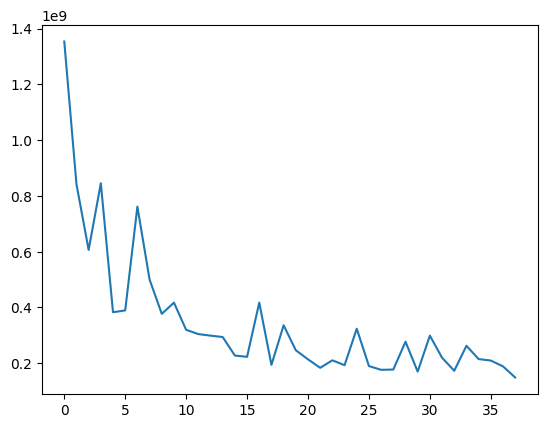

In [9]:
fig, ax = plt.subplots()

ax.plot(dictionary_target.history['OGMM_evolution'])

In [ ]:
fig, ax = plt.subplots()

for elt in dictionary.history['atoms_evolution']:
    ax.plot(elt)

# CWRU

In [2]:
target = 'C'
with open(os.path.join('data', 'mlp_fts_256_target_{}.pkl'.format(target)), 'rb') as f:
        dataset = pickle.loads(f.read())

Xs, ys = [], []
d = None
keys = list(dataset.keys())
for i in [0, 1]:
    features = dataset[keys[i]]['Features']
    labels = dataset[keys[i]]['Labels'].argmax(dim=1)
    domain = i*np.ones((features.shape[0], 1))
    Xs.append(features.float())
    ys.append(labels.float())
    if d is None:
        d = domain
    else:
        d = np.concatenate([d, domain], axis=0)

Xt = dataset[target]['fold 0']['Train']['Features'].float()
yt = dataset[target]['fold 0']['Train']['Labels'].float().argmax(dim=1)

Xt_test = dataset[target]['fold 0']['Test']['Features'].float()
yt_test = dataset[target]['fold 0']['Test']['Labels'].float().argmax(dim=1)
d = np.concatenate([d, 2*np.ones((Xt.shape[0], 1))], axis=0)

n_domains = int(np.max(d)) + 1
n_features = Xt.shape[1]
n_classes = int(np.max(yt.numpy())) + 1

In [22]:
results = test_dadil(Xs, ys, Xt, yt, Xt_test, yt_test, n_features, n_samples, n_classes, n_atoms, batch_size, n_iter)

It 1/100, Loss: 7410.03173828125
It 2/100, Loss: 5434.06708984375
It 3/100, Loss: 3959.6238281250003
It 4/100, Loss: 3018.6269531250005
It 5/100, Loss: 2338.546142578125
It 6/100, Loss: 1850.917724609375
It 7/100, Loss: 1472.7577880859374
It 8/100, Loss: 1172.9741455078126
It 9/100, Loss: 951.0959228515626
It 10/100, Loss: 774.662841796875
It 11/100, Loss: 645.2108642578124
It 12/100, Loss: 549.780419921875
It 13/100, Loss: 479.5917114257812
It 14/100, Loss: 420.4764526367187
It 15/100, Loss: 388.74168090820314
It 16/100, Loss: 339.52911987304685
It 17/100, Loss: 316.65272216796876
It 18/100, Loss: 288.9431945800781
It 19/100, Loss: 259.4006652832031
It 20/100, Loss: 261.90569763183595
It 21/100, Loss: 246.58533935546876
It 22/100, Loss: 225.20755920410159
It 23/100, Loss: 206.54473266601562
It 24/100, Loss: 207.5506866455078
It 25/100, Loss: 175.09521484375003
It 26/100, Loss: 163.00850524902341
It 27/100, Loss: 138.21900482177733
It 28/100, Loss: 113.83731994628907
It 29/100, Loss: 1

In [24]:
results

{'lin': {'wda': 0.7745833333333333,
  'e': 0.31083333333333335,
  'e_ot': 0.8665416666666668,
  'r': 0.8729166666666667,
  'r_ot': 0.9245833333333333},
 'rbf': {'wda': 0.78875,
  'e': 0.70875,
  'e_ot': 0.983875,
  'r': 0.9991666666666666,
  'r_ot': 0.9991666666666668},
 'RF': {'wda': 0.78,
  'e': 0.5916666666666667,
  'e_ot': 0.8619166666666667,
  'r': 0.9370833333333334,
  'r_ot': 0.8642916666666667}}

In [27]:
results_odadil = test_odadil(Xs, ys, Xt, yt, Xt_test, yt_test, n_features, n_samples, n_classes, n_atoms, batch_size, n_iter)

It 1/100, Loss: 6293.8759765625
It 2/100, Loss: 4682.848535156249
It 3/100, Loss: 3421.94736328125
It 4/100, Loss: 2578.3666503906247
It 5/100, Loss: 2062.232421875
It 6/100, Loss: 1620.34677734375
It 7/100, Loss: 1305.6499999999999
It 8/100, Loss: 1061.6853759765627
It 9/100, Loss: 859.5136474609375
It 10/100, Loss: 696.1669067382812
It 11/100, Loss: 569.10986328125
It 12/100, Loss: 471.69270019531245
It 13/100, Loss: 388.2576110839844
It 14/100, Loss: 325.369189453125
It 15/100, Loss: 272.4176239013672
It 16/100, Loss: 230.7188262939453
It 17/100, Loss: 195.6434356689453
It 18/100, Loss: 166.90877685546874
It 19/100, Loss: 143.29924926757812
It 20/100, Loss: 123.6897201538086
It 21/100, Loss: 109.82488250732422
It 22/100, Loss: 96.57325744628906
It 23/100, Loss: 85.04256591796874
It 24/100, Loss: 77.36022491455078
It 25/100, Loss: 69.84381866455078
It 26/100, Loss: 63.04319915771484
It 27/100, Loss: 57.51739349365235
It 28/100, Loss: 52.16697235107422
It 29/100, Loss: 48.472456359863

In [29]:
results_odadil

{'lin': {'wda': 0.7745833333333333,
  'e': 0.8008333333333333,
  'e_ot': 0.9652916666666667,
  'r': 0.84625,
  'r_ot': 0.9637499999999999},
 'rbf': {'wda': 0.78875,
  'e': 0.8033333333333333,
  'e_ot': 0.9929166666666667,
  'r': 0.7995833333333333,
  'r_ot': 0.9870833333333333},
 'RF': {'wda': 0.8129166666666666,
  'e': 0.7533333333333333,
  'e_ot': 0.9692916666666666,
  'r': 0.7095833333333333,
  'r_ot': 0.9678333333333333}}

In [4]:
before_online_results, after_online_results = test_forgetting_odadil(Xs, ys, Xt, yt, Xt_test, yt_test, n_features, n_samples, n_classes, n_atoms, batch_size, n_iter)

It 1/100, Loss: 6091.7953125
It 2/100, Loss: 4562.152685546876
It 3/100, Loss: 3352.66650390625
It 4/100, Loss: 2476.6739257812505
It 5/100, Loss: 1899.0962646484377
It 6/100, Loss: 1516.027783203125
It 7/100, Loss: 1199.124169921875
It 8/100, Loss: 975.3376342773438
It 9/100, Loss: 787.5294677734375
It 10/100, Loss: 642.01572265625
It 11/100, Loss: 521.2331787109375
It 12/100, Loss: 429.1922607421875
It 13/100, Loss: 354.8529235839844
It 14/100, Loss: 293.1774475097656
It 15/100, Loss: 246.8191375732422
It 16/100, Loss: 208.0216796875
It 17/100, Loss: 174.36480407714845
It 18/100, Loss: 148.93609008789062
It 19/100, Loss: 127.42293243408204
It 20/100, Loss: 110.90953979492187
It 21/100, Loss: 96.91039733886718
It 22/100, Loss: 85.8267822265625
It 23/100, Loss: 76.13201599121093
It 24/100, Loss: 68.51965484619141
It 25/100, Loss: 61.888249206542966
It 26/100, Loss: 55.80079879760742
It 27/100, Loss: 51.657005310058594
It 28/100, Loss: 47.61237182617188
It 29/100, Loss: 44.6593063354492

In [7]:
before_online_results

{'lin': {'r': [1.0, 1.0], 'r_ot': [1.0, 0.9985000000000002]},
 'rbf': {'r': [1.0, 1.0], 'r_ot': [1.0, 1.0]},
 'RF': {'r': [1.0, 1.0], 'r_ot': [1.0, 0.9966250000000001]}}

In [8]:
after_online_results

{'lin': {'r': [1.0, 1.0], 'r_ot': [0.998875, 0.9971250000000003]},
 'rbf': {'r': [1.0, 1.0], 'r_ot': [1.0, 1.0]},
 'RF': {'r': [1.0, 1.0], 'r_ot': [0.998, 0.9960000000000002]}}

In [9]:
c = 0
m = 0
for kc in before_online_results.keys():
    for kd in before_online_results[kc].keys():
        for i in range(len(before_online_results[kc][kd])):
            c += 1
            m += after_online_results[kc][kd][i]/before_online_results[kc][kd][i]
m/c

0.9995725681569461